# Demonstration: Recourse-Aware Classification Tree (RACT)
A demonstration of *Recourse-Aware Classification Tree (RACT)*. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

from ract import Action, RecourseTreeClassifier
from datasets import Dataset

results = {
    'Method': [],
    'Accuracy': [], 
    'Recourse': []
}

## Step 1. Prepare Dataset
Before learning classification trees, we prepare a dataset. 
In this library, we provide (1) ``Dataset`` class for handling sample datasets in ``./datasets`` directory and (2) ``preprocess`` function for handling a passed DataFrame. 
We need to specify the constraint on each feature in the dataset (e.g., immutable or not, increasing only, ...). 

In [2]:
D = Dataset('b')
X_tr, X_ts, y_tr, y_ts = D.get_dataset(split=True)
params = D.params

y_target = 0
max_depth = 3
cost_type = 'MPS'
cost_budget = 0.3

D.get_details()

,Feature,Type,Min,Max,Immutable,Constraint
0,White,Binary,0.0,1.0,Yes,Fix
1,Alchy,Binary,0.0,1.0,No,Nothing
2,Junky,Binary,0.0,1.0,No,Nothing
3,Super,Binary,0.0,1.0,Yes,Fix
4,Married,Binary,0.0,1.0,Yes,Fix
5,Felon,Binary,0.0,1.0,Yes,Fix
6,Workrel,Binary,0.0,1.0,No,Nothing
7,Propty,Binary,0.0,1.0,Yes,Fix
8,Person,Binary,0.0,1.0,Yes,Fix
9,Male,Binary,0.0,1.0,Yes,Fix


## Step 2. Learning Classification Tree
For the preprocessed dataset, we learn classification trees and extract recourse actions from them. 
Our library consists of two classes: ``Action`` class for maintaining and optimizing actions; ``RecourseTreeClassifier`` class for learning classification trees with the constraint on recourse actions. 
Here, we compare our RACT to two standard baselines. 

### [Baseline 1] Standard Learning Algorithm (Vannilla)
One baseline method is a standard learning algorithm; that is, learning classification trees with no constraint on recourse. 
We can use this method by setting ``alpha = 0.0``. 

In [3]:
action = Action(X_tr, y_target=y_target, cost_type=cost_type, cost_budget=cost_budget, **params)
clf = RecourseTreeClassifier(action, max_depth=max_depth)

clf.action.alpha = 0.0
clf = clf.fit(X_tr, y_tr)

X_target = X_ts[clf.predict(X_ts) != action.y_target]
actions = clf.explain_action(X_target)

results['Method'].append('Vanilla')
results['Accuracy'].append(clf.score(X_ts, y_ts))
results['Recourse'].append(1 - (~actions['cost-validity']).sum() / X_ts.shape[0])

clf.draw_tree()

### [Baseline 2] Learning with Only Actionable Feature (OAF)
Another baseline approach is to learn classification trees using only actionable features, i.e., features that can be changed by actions. 
We can use this method by setting ``alpha = 0.0`` and ``feature_masking = True``. 

In [4]:
action = Action(X_tr, y_target=y_target, cost_type=cost_type, cost_budget=cost_budget, **params)
clf = RecourseTreeClassifier(action, max_depth=max_depth, feature_masking=True)

clf.action.alpha = 0.0
clf = clf.fit(X_tr, y_tr)

X_target = X_ts[clf.predict(X_ts) != action.y_target]
actions = clf.explain_action(X_target)

results['Method'].append('OAF')
results['Accuracy'].append(clf.score(X_ts, y_ts))
results['Recourse'].append(1 - (~actions['cost-validity']).sum() / X_ts.shape[0])

clf.draw_tree()

### [Proposed] Recourse-Aware Classification Tree (RACT)
Our proposed approach, named RACT, is to learn classification trees while guaranteeing the existence of recourse actions. 
We can use RACT by setting ``alpha > 0``. 

In [5]:
action = Action(X_tr, y_target=y_target, cost_type=cost_type, cost_budget=cost_budget, **params)
clf = RecourseTreeClassifier(action, max_depth=max_depth)

clf.action.alpha = 0.1
clf = clf.fit(X_tr, y_tr)

X_target = X_ts[clf.predict(X_ts) != action.y_target]
actions = clf.explain_action(X_target)

results['Method'].append('RACT')
results['Accuracy'].append(clf.score(X_ts, y_ts))
results['Recourse'].append(1 - (~actions['cost-validity']).sum() / X_ts.shape[0])

clf.draw_tree()

## Step 3. Compare Performance
Now, we compare the performance of RACT to those of the baselines. 
We can see that RACT could guarantee recourse actions for more individuals than the baselines (right figure), while maintaining comparable accuracy to them (left figure). 

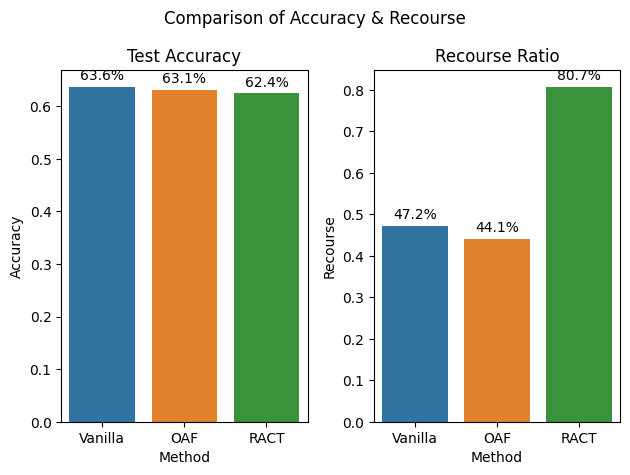

In [6]:
results = pd.DataFrame(results)

plt.subplot(1, 2, 1)
plots = sns.barplot(x='Method', y="Accuracy", data=results)
for bar in plots.patches:
  plots.annotate('{:.1%}'.format(bar.get_height()), (bar.get_x() + bar.get_width()/2, bar.get_height()), 
                 ha='center', va='center',size=10, xytext=(0, 8), textcoords='offset points')
plt.title('Test Accuracy')

plt.subplot(1, 2, 2)
plots = sns.barplot(x='Method', y="Recourse", data=results)
for bar in plots.patches:
  plots.annotate('{:.1%}'.format(bar.get_height()), (bar.get_x() + bar.get_width()/2, bar.get_height()), 
                 ha='center', va='center',size=10, xytext=(0, 8), textcoords='offset points')
plt.title('Recourse Ratio')

plt.suptitle('Comparison of Accuracy & Recourse')
plt.tight_layout()